In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime as dt
import shutil

In [50]:
plt.rcParams.update({'figure.max_open_warning': 0})

## Read data and obtain key parameter lists to iterate over and group dataframe into subsets of chemicals, hydro areas, and wells

In [51]:
pth = os.getcwd()
data = os.path.join(pth,'data','wqtimeseries.csv')

In [52]:
begin = 1967
end = 2020
threshold = 5
outpath = 'mayb'

## Set maximum limits for y-axes for each chemical

In [53]:
yaxis_dict = {'nitrate_as_n': 25, 'nitrate_as_no3': 120, 'tds': 1500, 'sulfate': 750, 'chloride': 200, 'boron': 1.5}

# TODO: create additional function to preprocess dms import table in pandas(remove extra columns and rename columns, rename for chemicals and areas, filter period of record)

In [54]:
def read_data(data):
    df = pd.read_csv(data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['area'].fillna('none', inplace=True)
    wells = df['well'].unique().tolist()
    chems = df['chem'].unique().tolist()
    areas = df['area'].unique().tolist()
    return df,chems,areas,wells

## Create new subdirectories and overwrite if athey already

In [61]:
def make_dirs(chems,areas):
    for chem in chems:
        for area in areas:
            subdir = f"{outpath}/{chem}/{area}"
            if os.path.exists(subdir):
                shutil.rmtree(subdir)
            os.makedirs(subdir)

## plot chemographs

In [63]:
def plt_chemographs(threshold,begin,end,outpath):
    df,chems,areas,wells = read_data(data)
    make_dirs(chems,areas)
    period = [dt.date(begin, 1, 1), dt.date(end, 1, 1)]
    record = pd.date_range(dt.date(begin, 1, 1), dt.date(end, 1, 1),freq='M')
    record_length = len(record)
    filt = (df.index >= str(begin)) & (df.index <= str(end))
    df = df.loc[filt]
    df_out = pd.DataFrame(columns=df.columns.tolist())
    for chem in chems:
        ylim = yaxis_dict[chem]
        for area in areas:
            for well in wells:
                df_well = df.loc[(df['well'] == well) & (df['chem'] == chem) & (df['area'] == area)]
                df_well = df_well.loc[~df_well.index.duplicated()]
                if not df_well.empty:
                    if df_well['find'].dropna().count() >= threshold:
                        fig,ax=plt.subplots()
                        line1, = ax.plot(df_well.index, df_well['find'], dashes=[4,2],
                                         marker='o', markersize=5,label='meas. conc.',
                                         c='limegreen',linewidth=2.5)
                        line2, = ax.plot(record, np.repeat(df_well['wqo'].mean(),record_length), label = 'wqo',c='red')
                        #ax.legend(loc='center left')
                        ax.spines['top'].set_visible(False)
                        ax.spines['right'].set_visible(False)
                        ax.spines['bottom'].set_visible(False)
                        ax.spines['left'].set_visible(False)
                        ax.set_xlim(period)
                        ax.set_ylim(0,ylim)
                        ax.set_ylabel('Concentration (mg/l)')
                        plt.title(f"{well}")
                        axes = plt.gca()
                        axes.yaxis.grid()
                        df_out = df_out.append(df_well)
                        fig.savefig(f"./{outpath}/{chem}/{area}/{well}.png")
            #wellist =  df_out['well'].unique().size
            #print(f'{chem}:{area}: {wellist}')
    df_out.to_csv('df_output.csv')

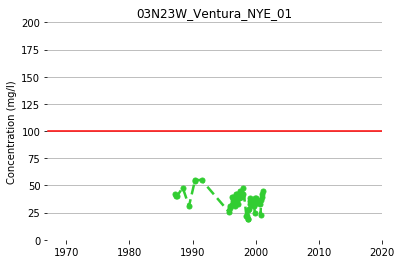

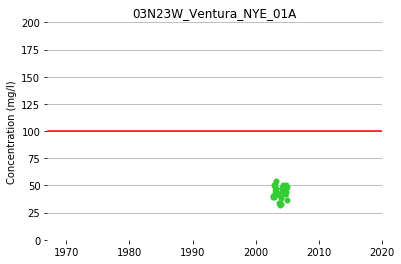

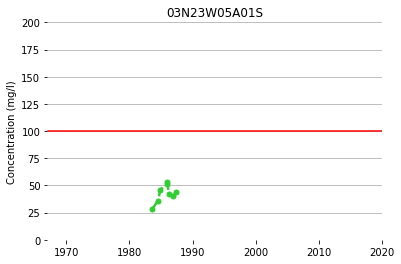

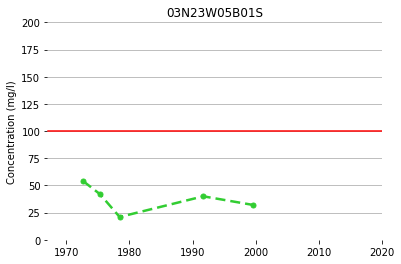

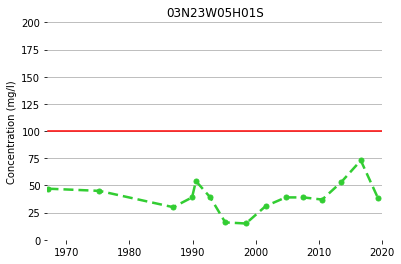

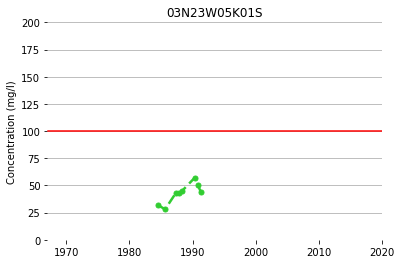

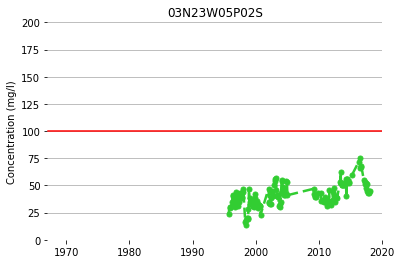

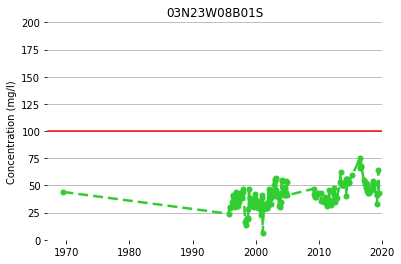

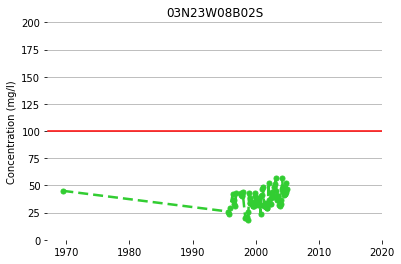

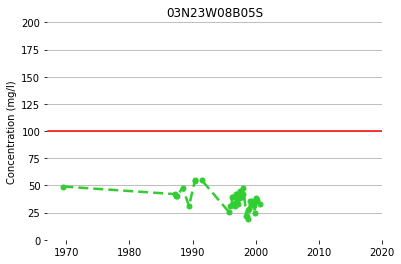

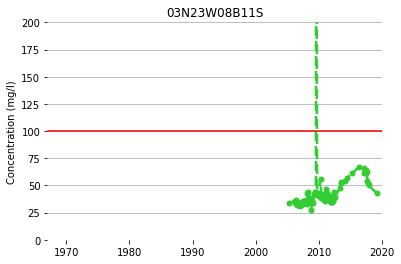

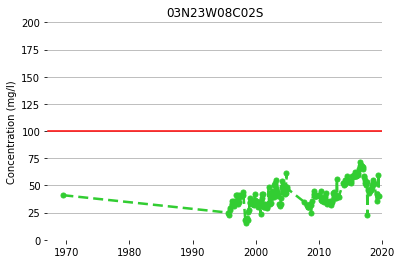

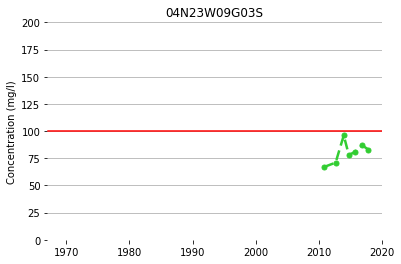

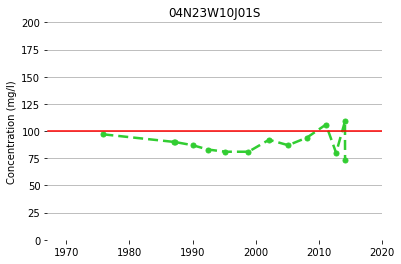

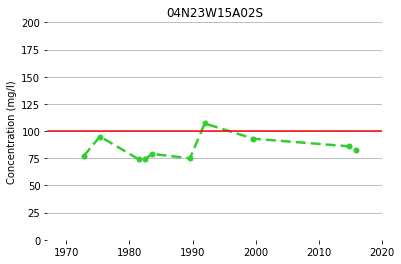

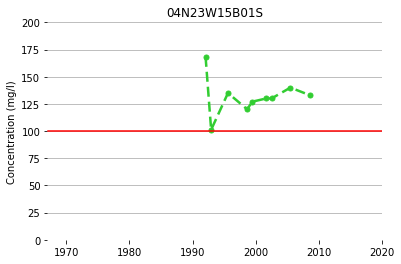

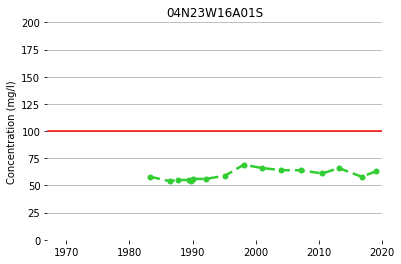

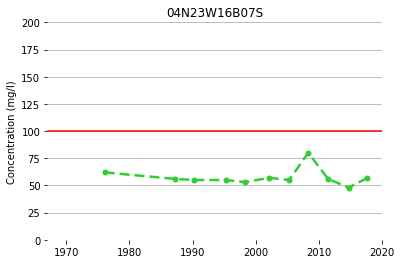

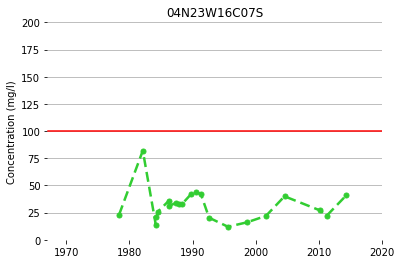

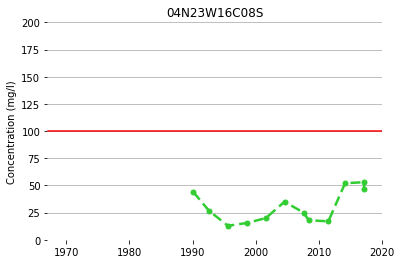

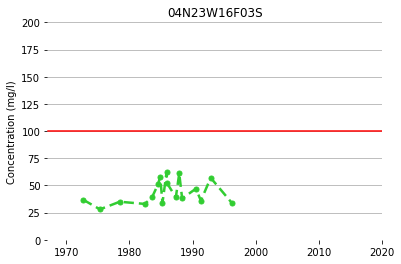

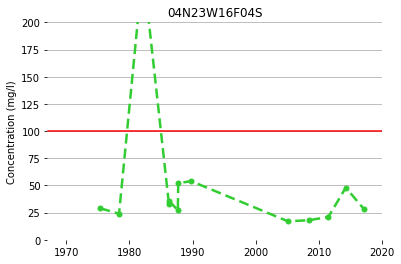

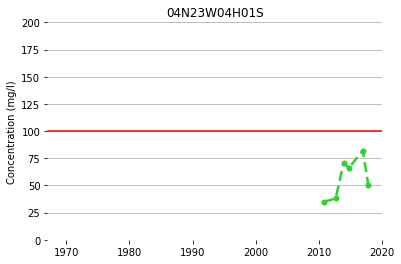

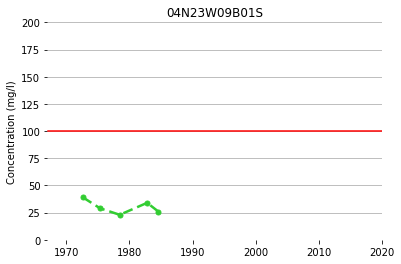

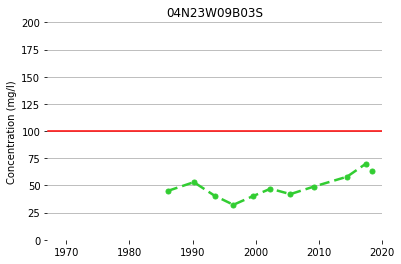

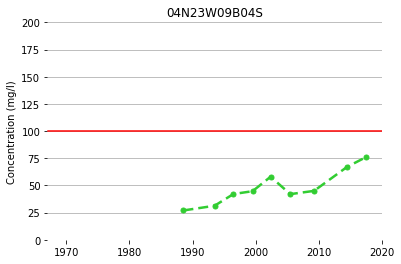

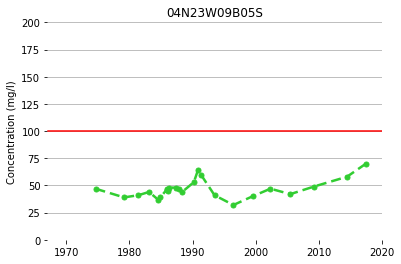

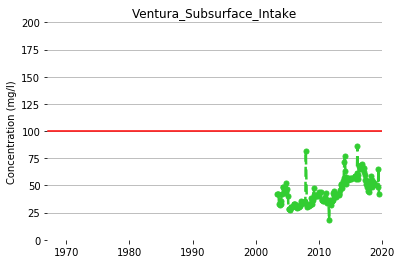

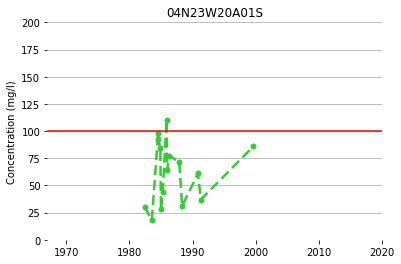

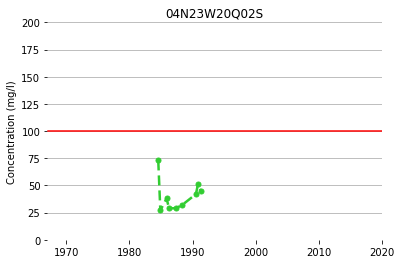

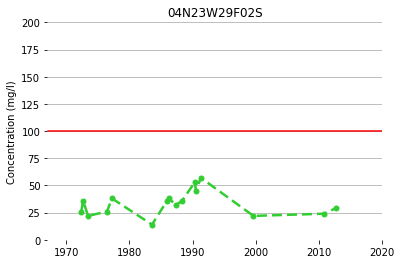

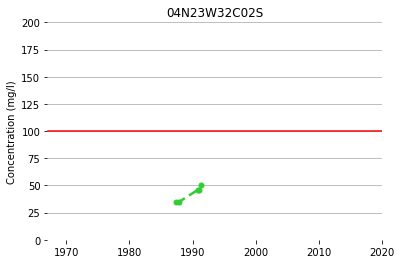

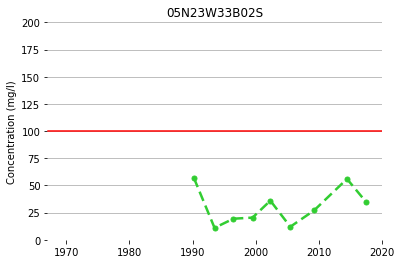

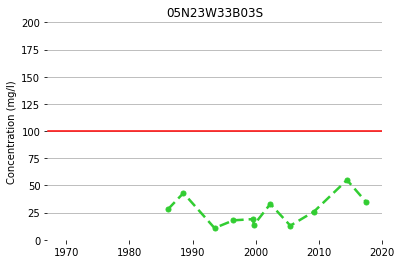

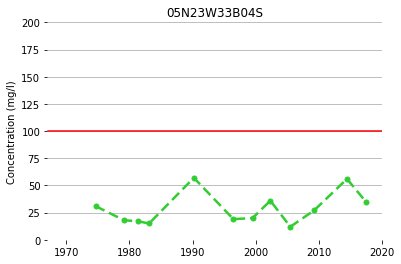

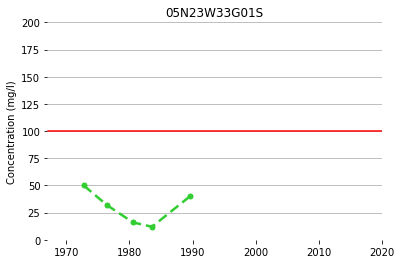

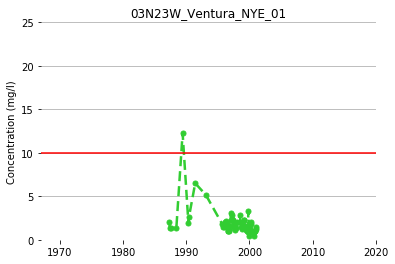

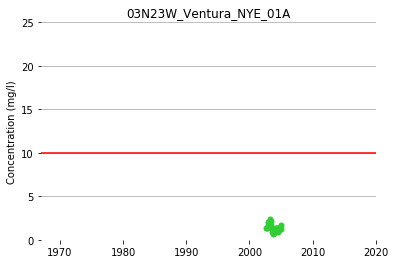

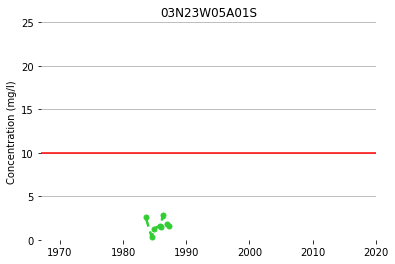

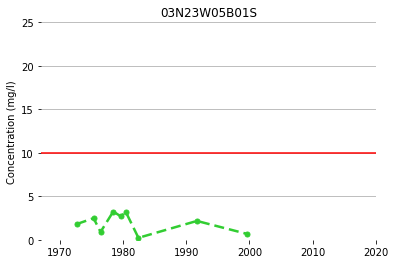

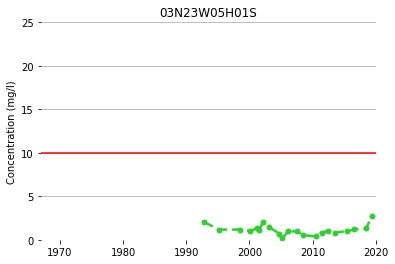

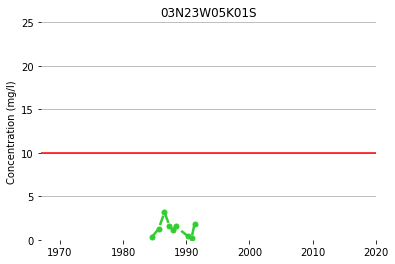

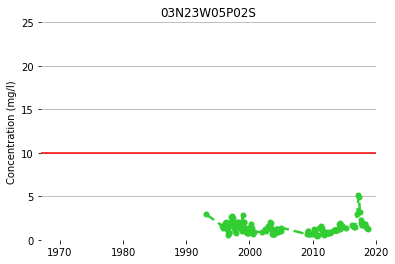

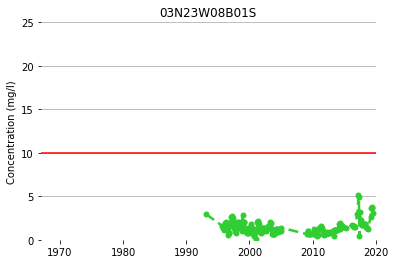

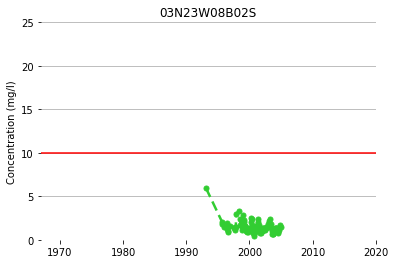

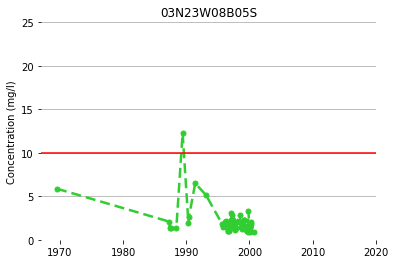

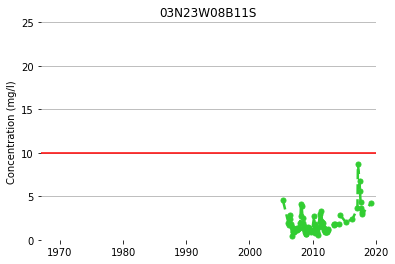

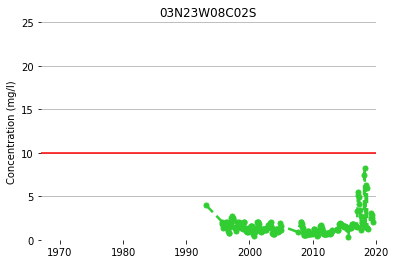

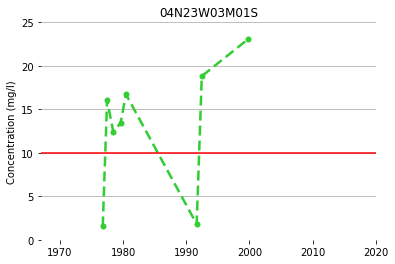

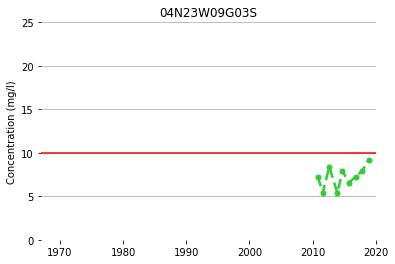

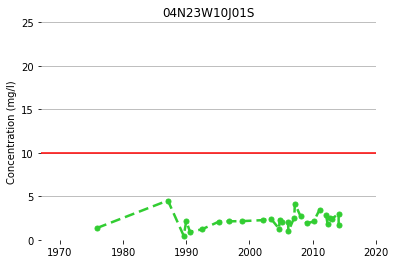

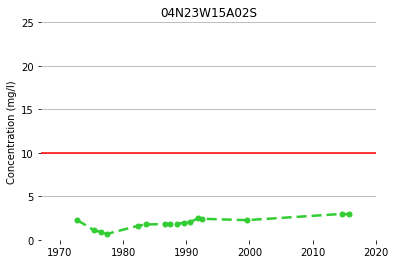

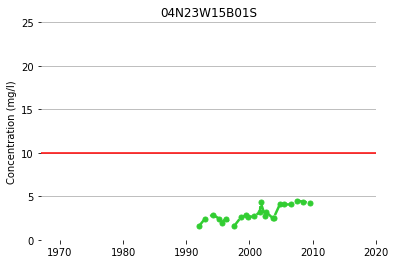

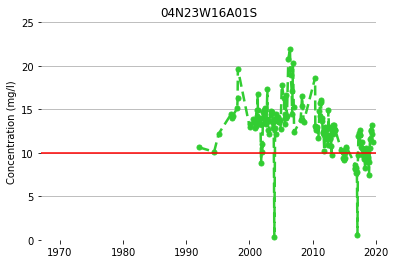

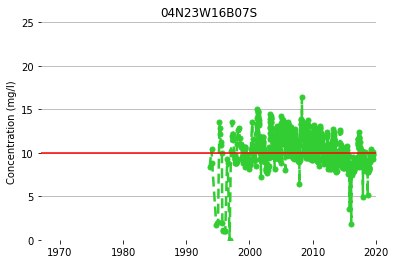

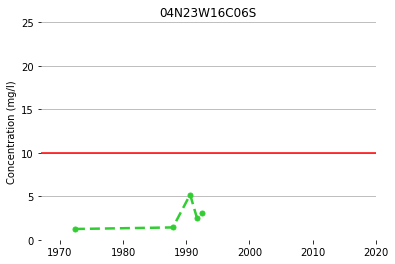

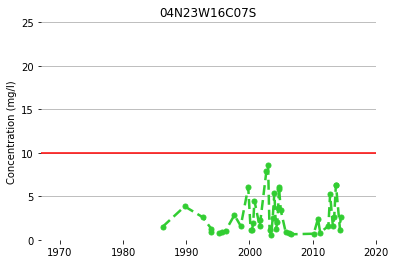

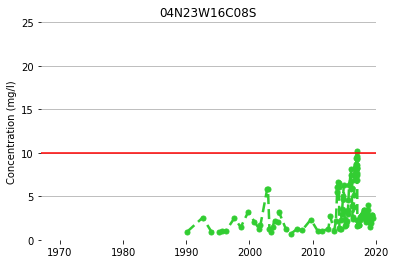

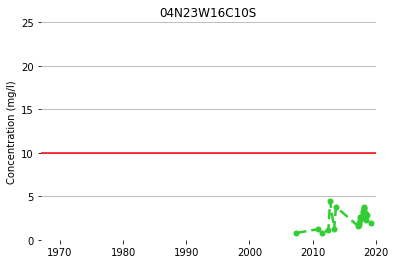

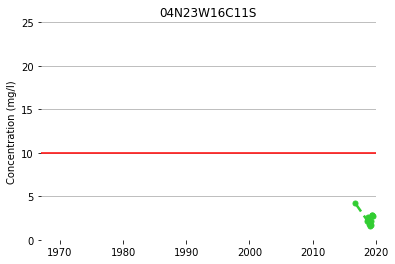

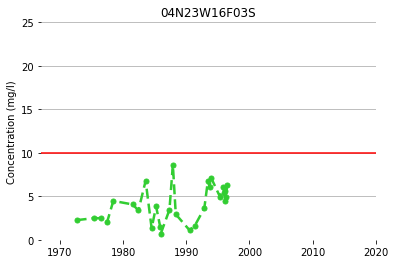

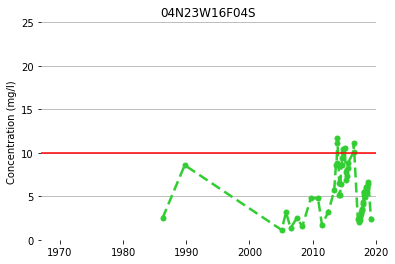

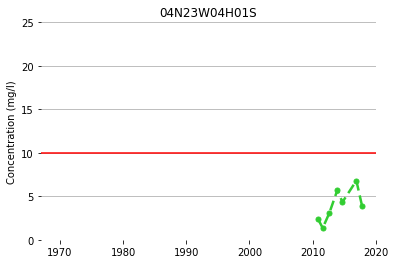

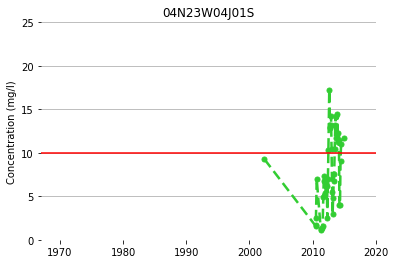

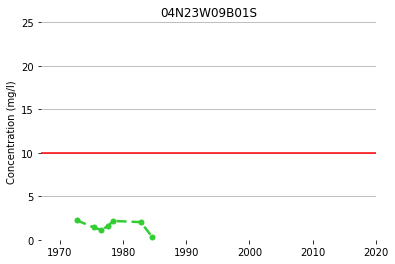

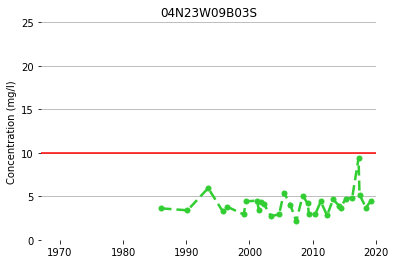

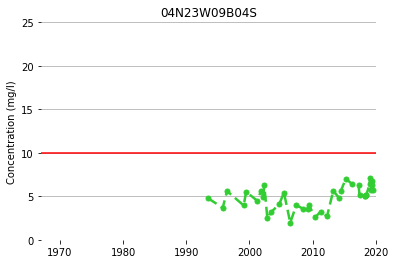

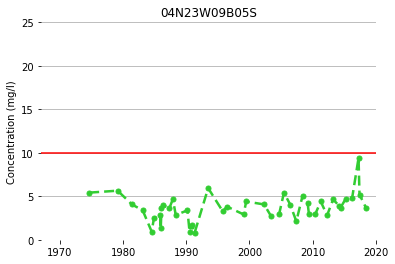

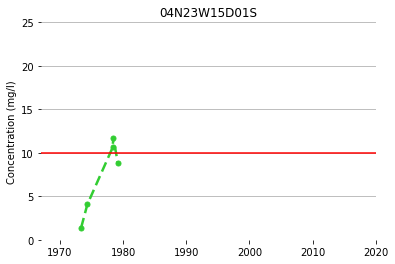

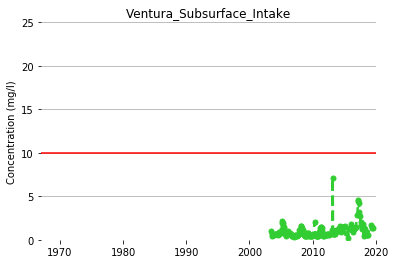

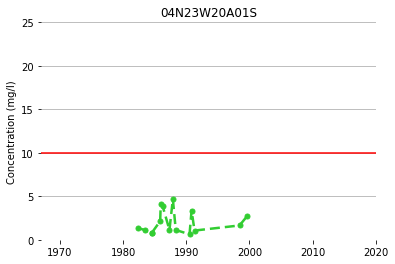

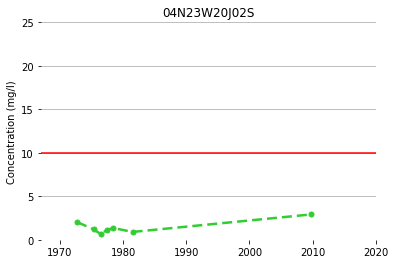

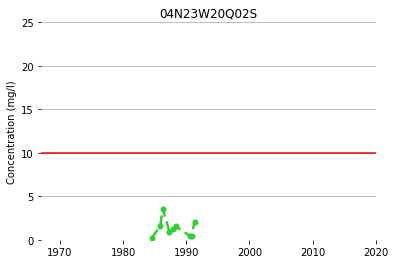

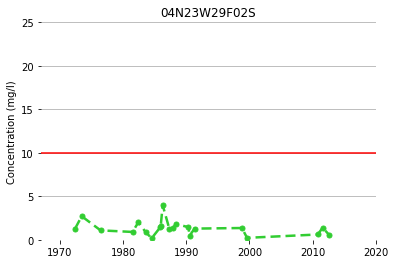

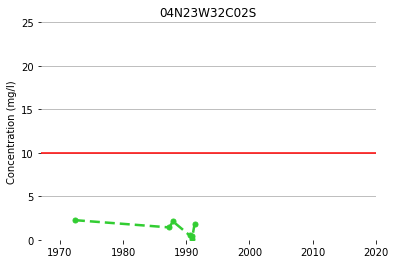

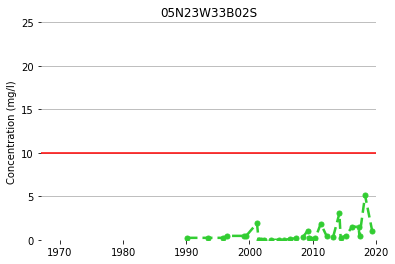

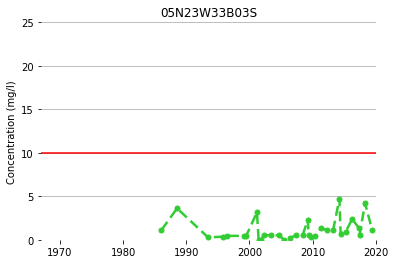

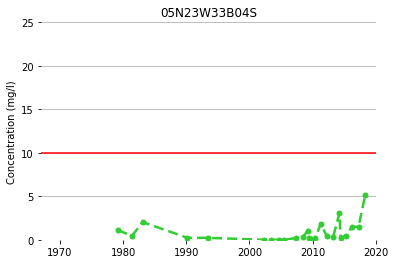

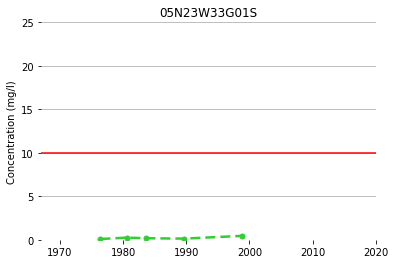

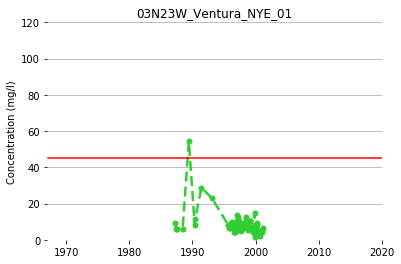

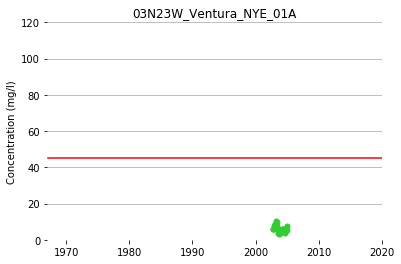

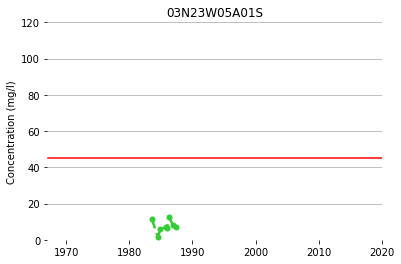

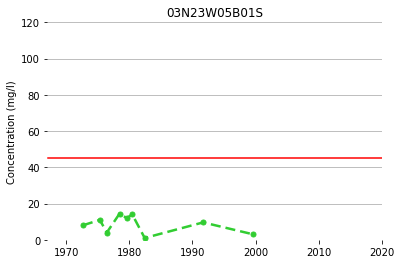

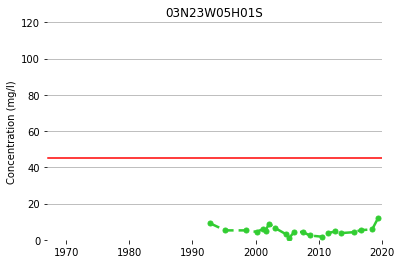

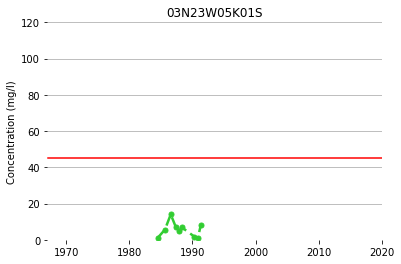

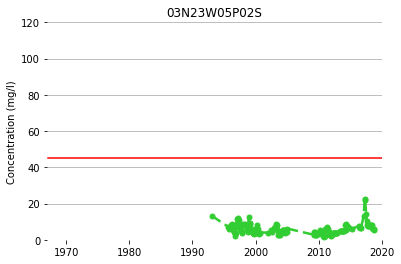

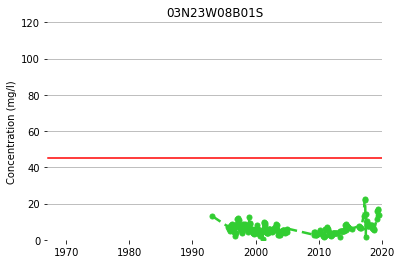

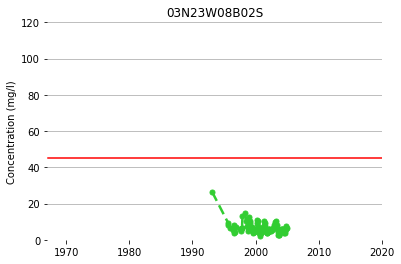

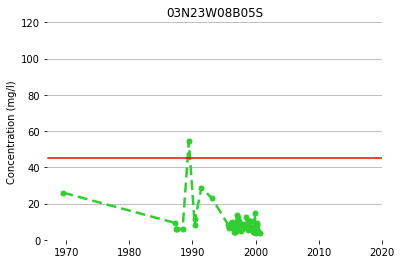

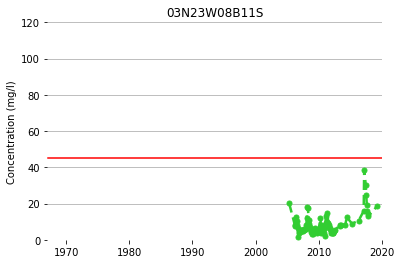

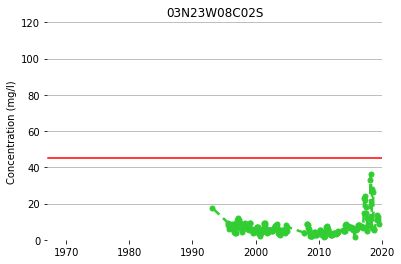

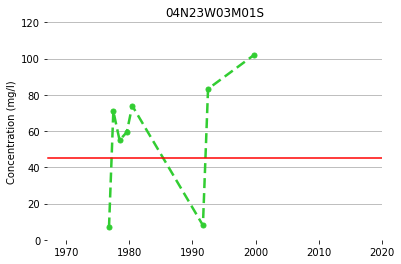

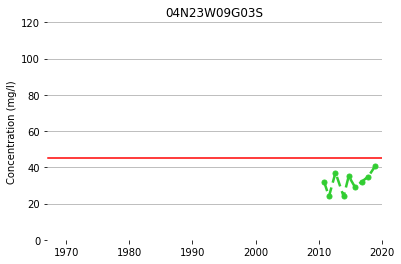

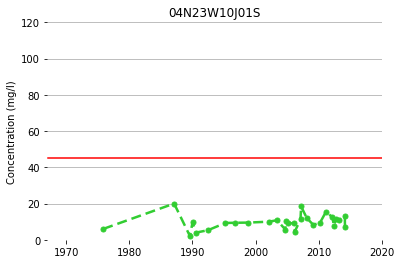

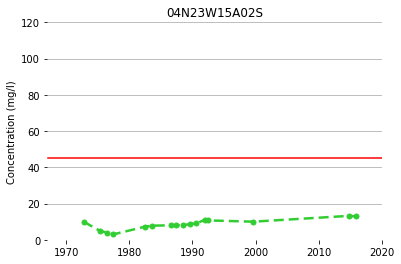

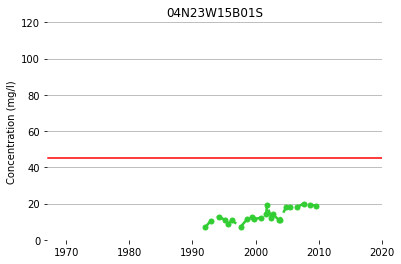

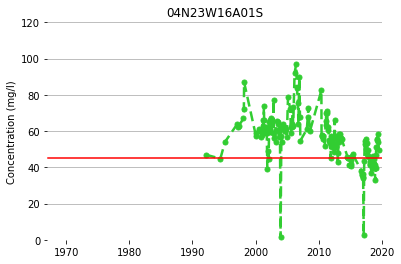

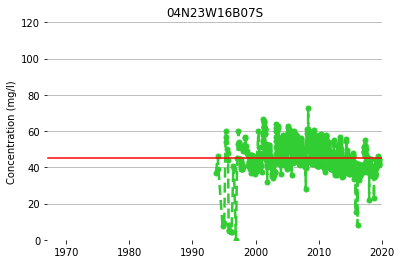

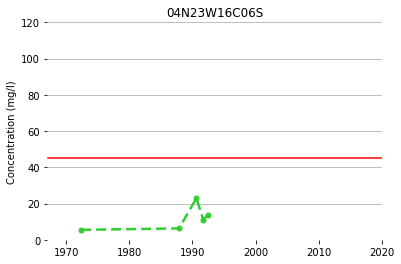

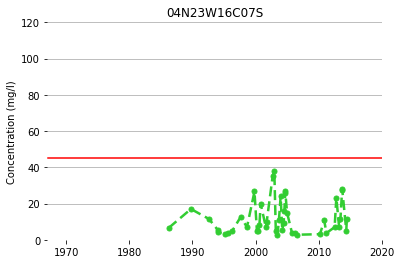

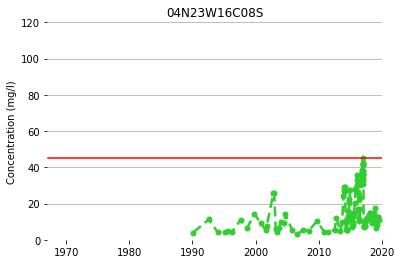

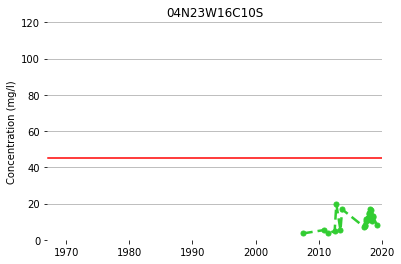

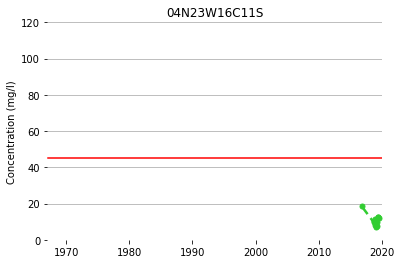

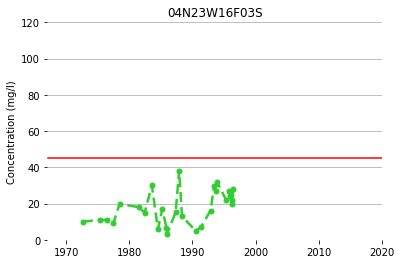

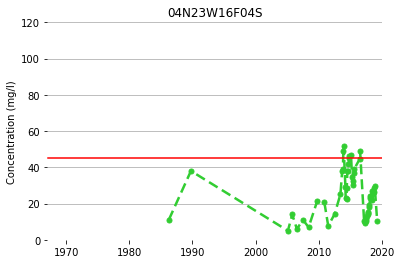

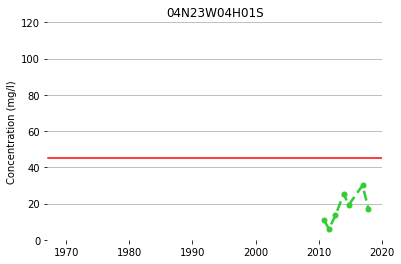

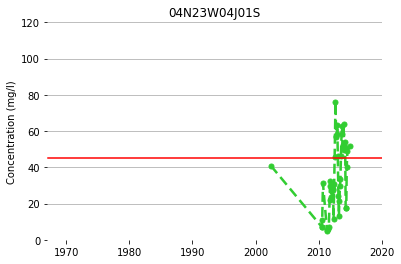

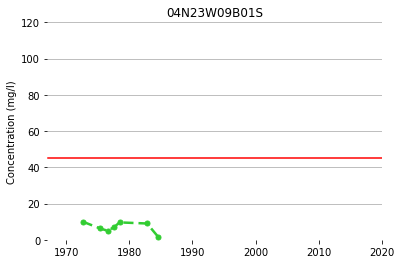

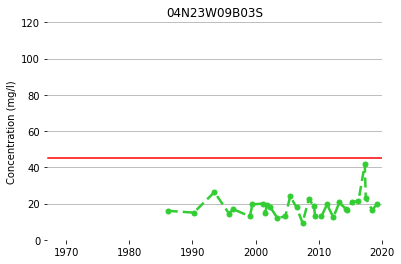

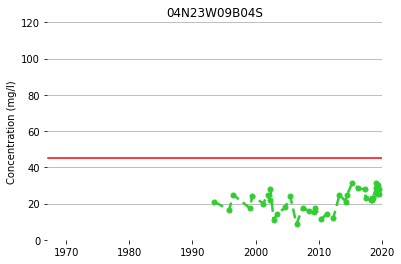

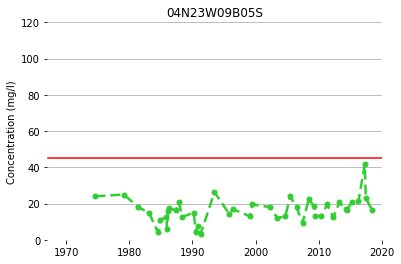

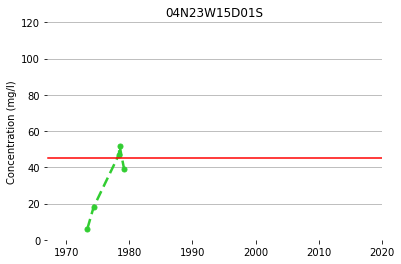

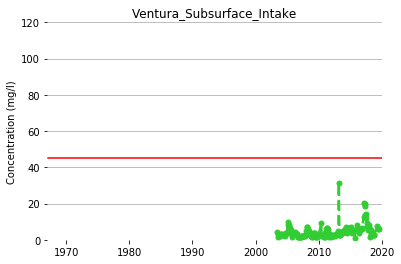

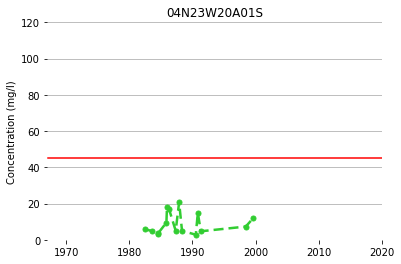

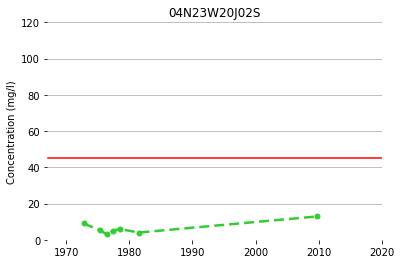

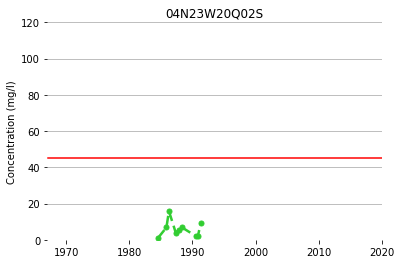

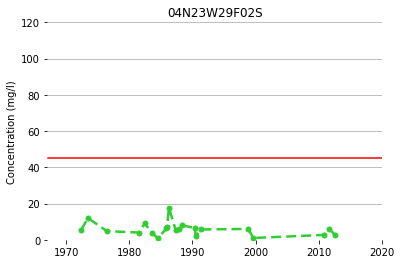

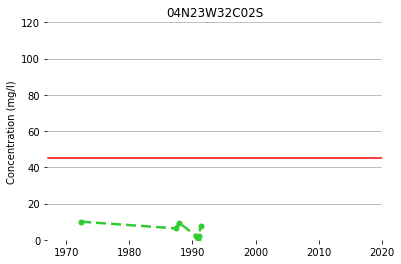

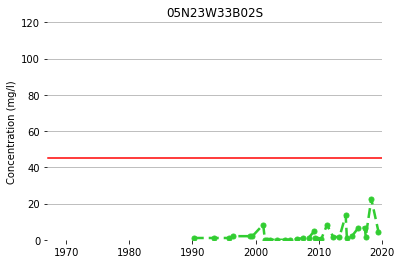

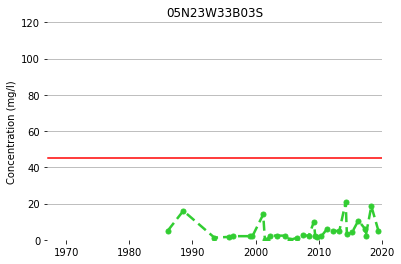

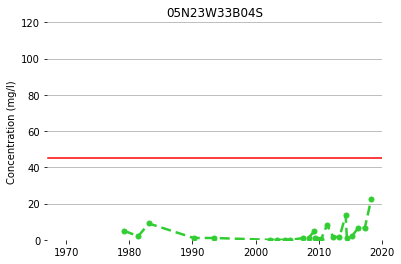

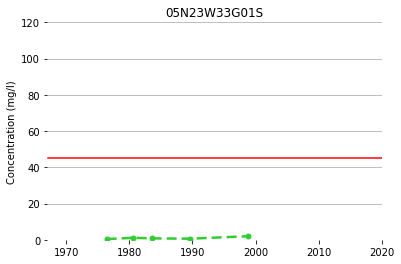

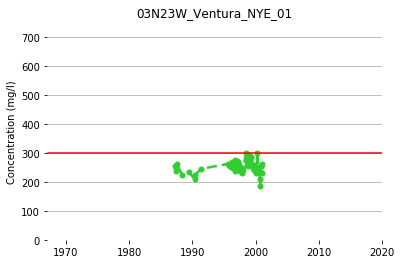

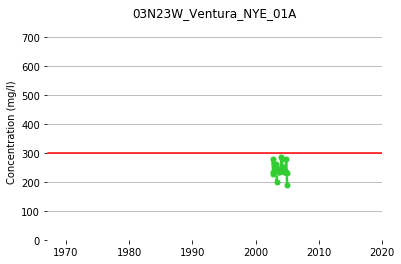

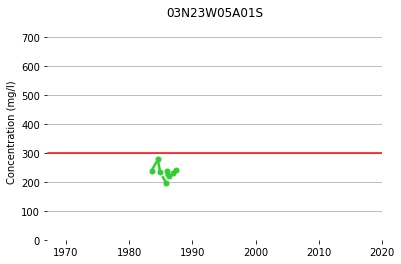

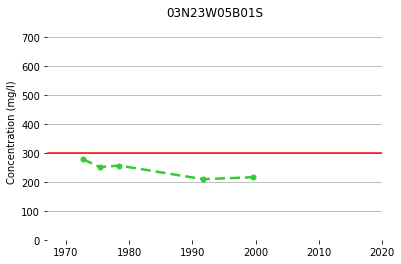

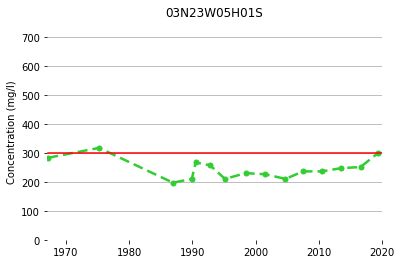

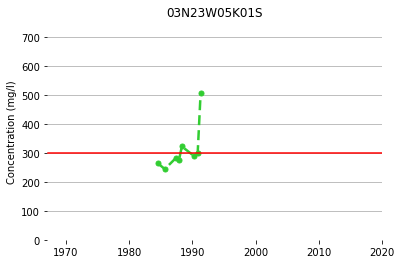

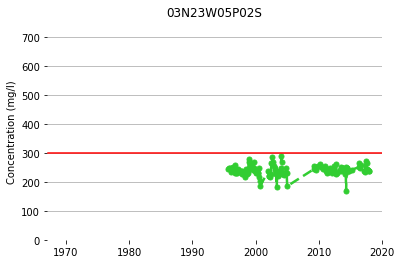

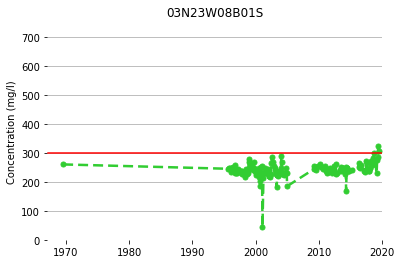

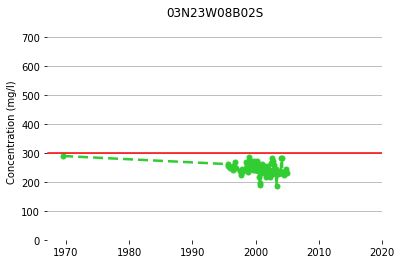

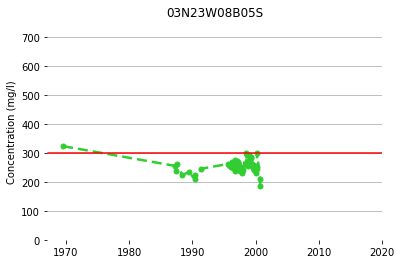

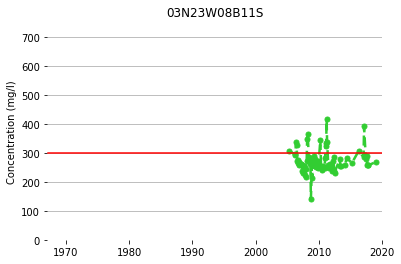

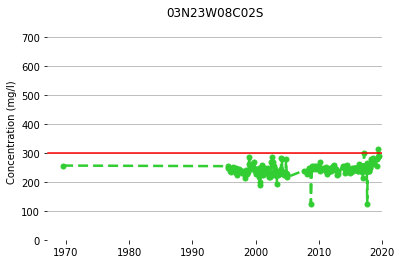

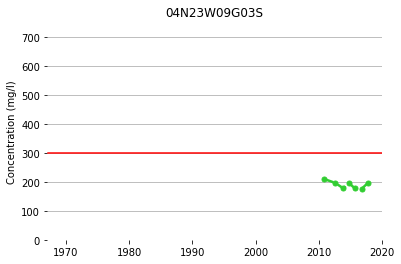

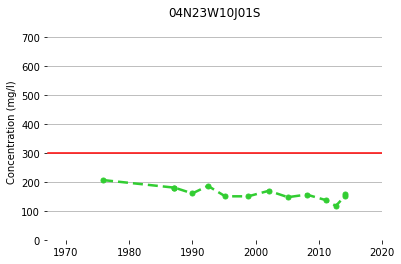

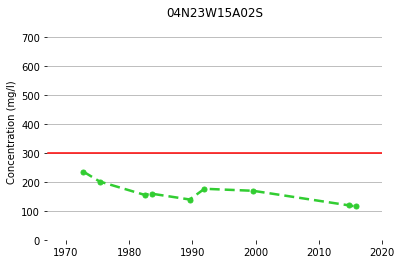

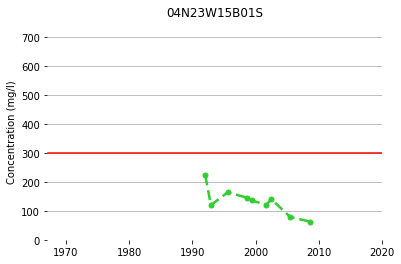

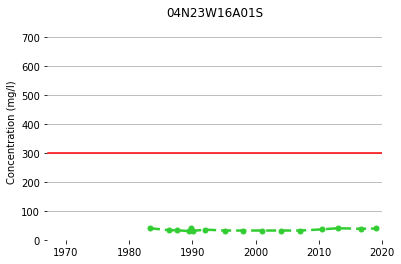

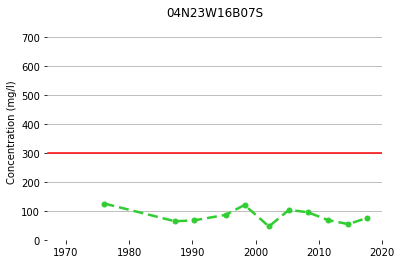

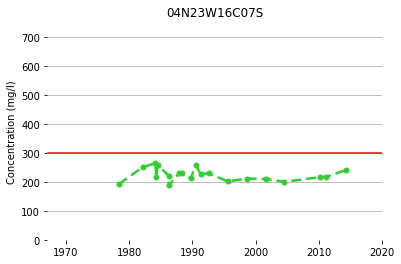

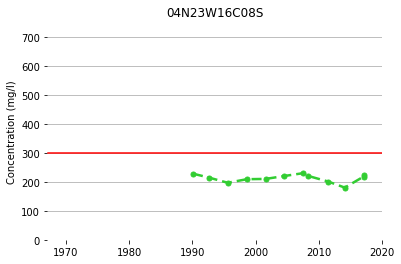

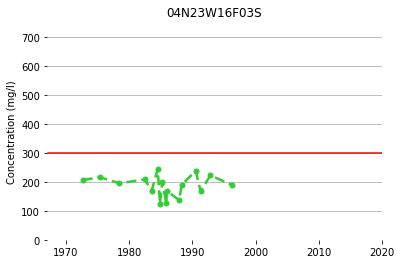

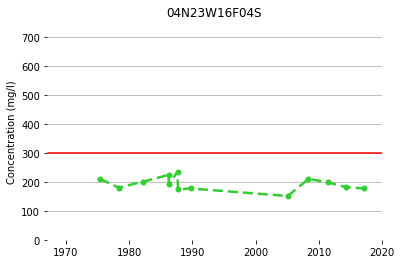

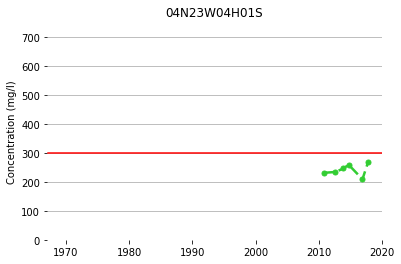

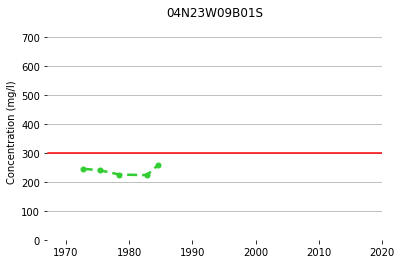

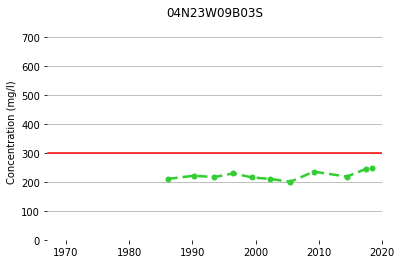

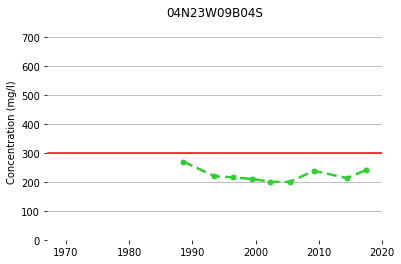

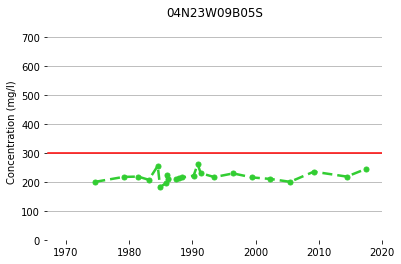

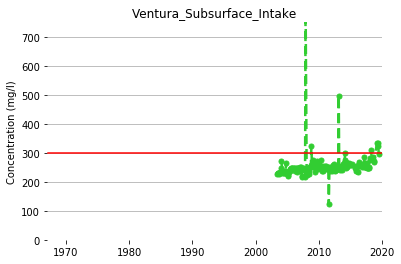

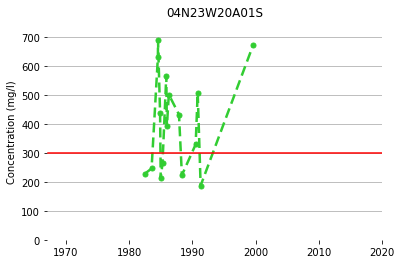

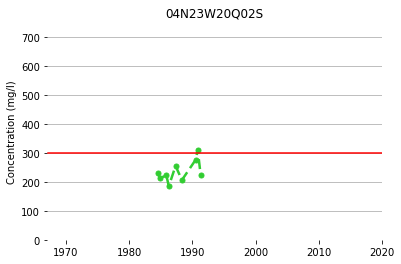

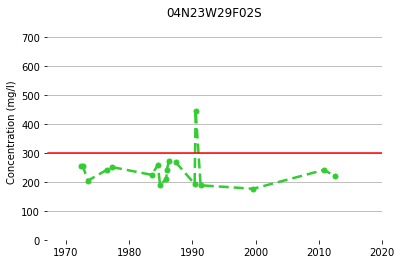

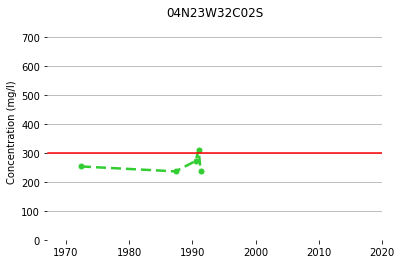

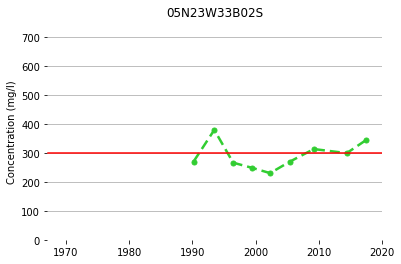

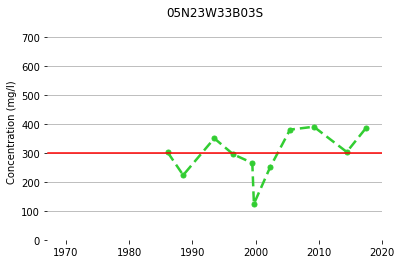

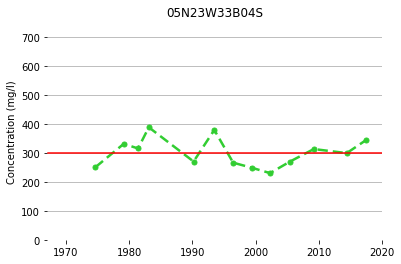

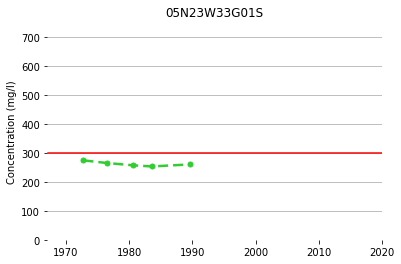

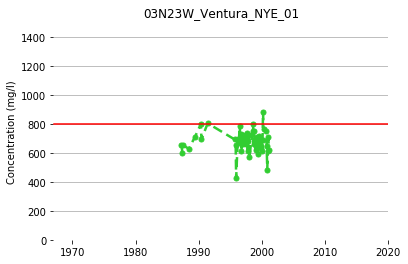

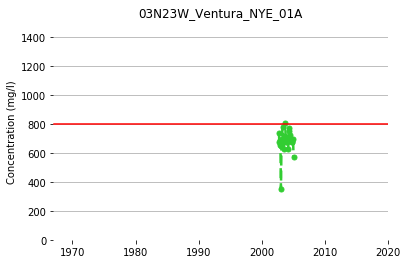

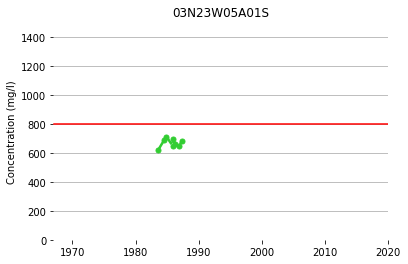

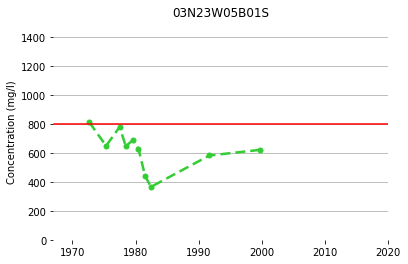

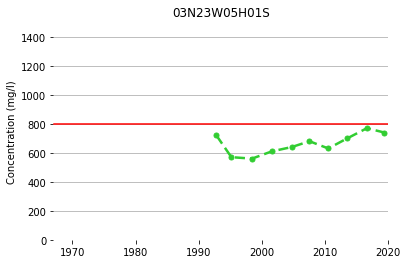

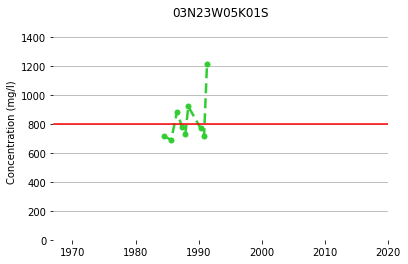

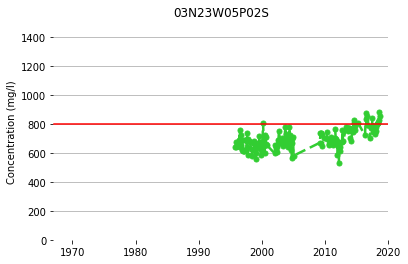

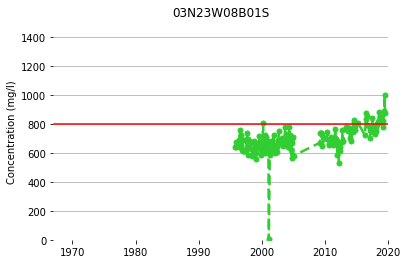

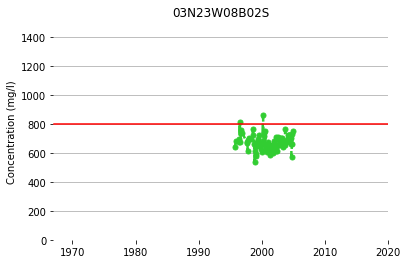

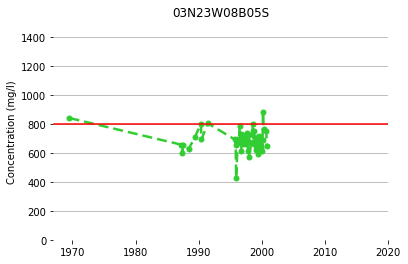

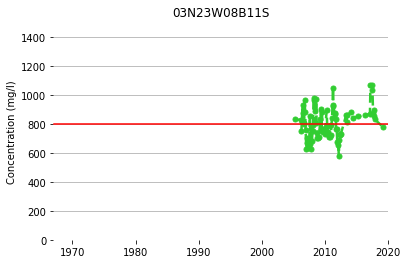

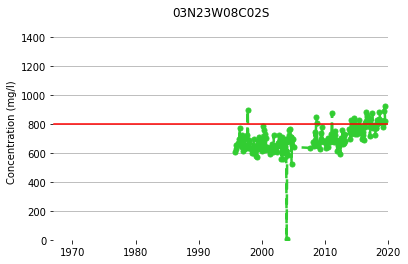

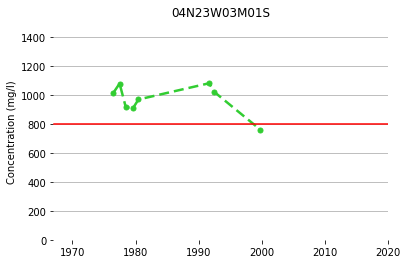

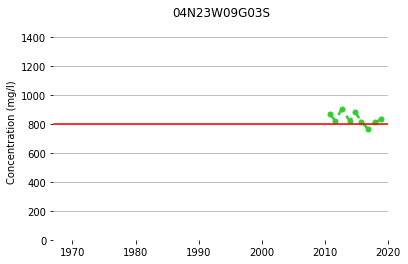

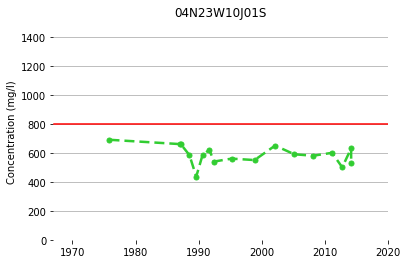

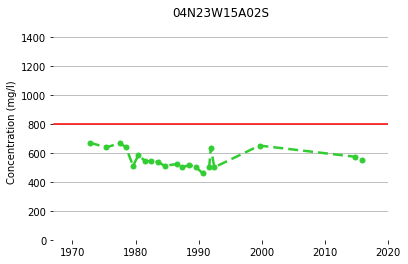

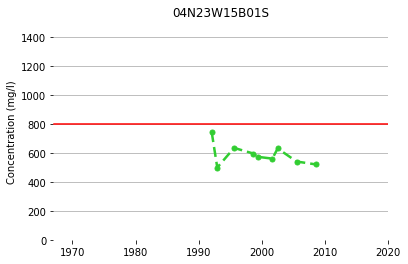

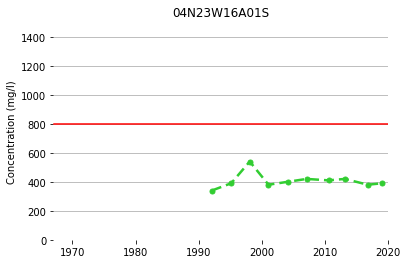

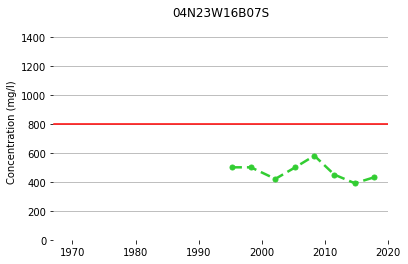

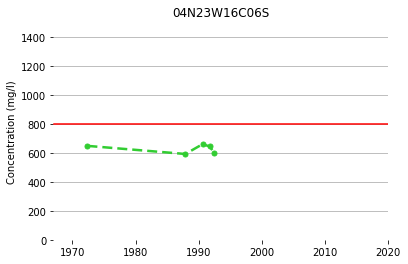

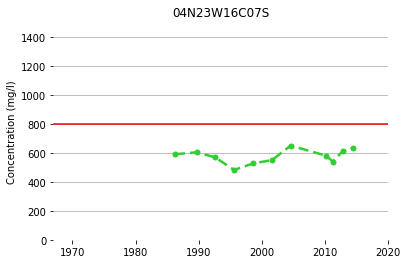

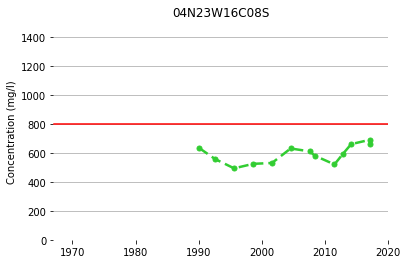

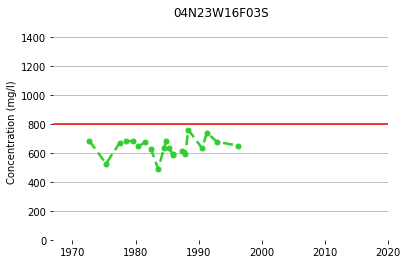

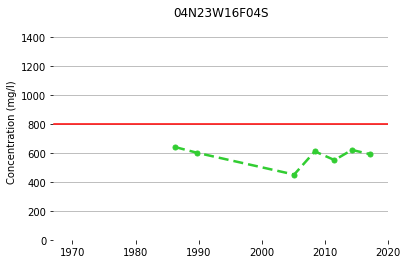

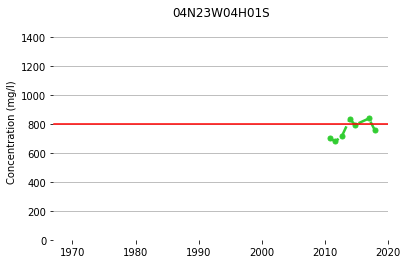

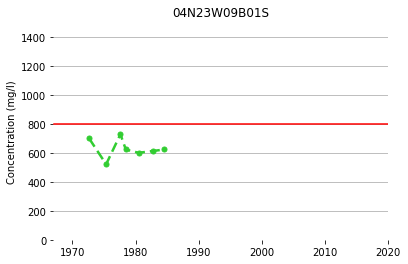

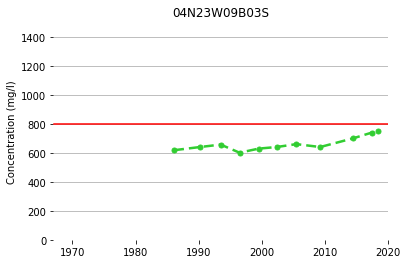

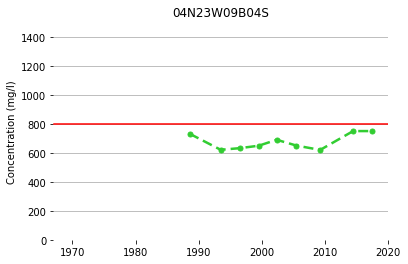

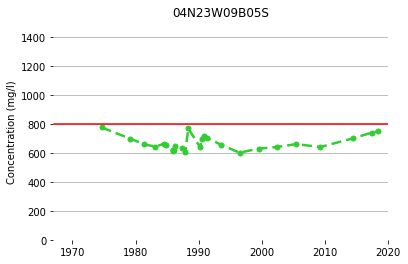

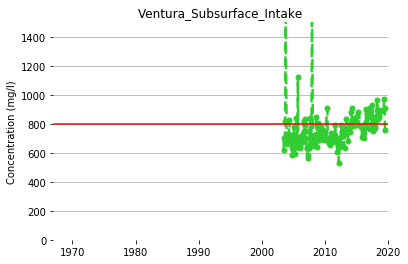

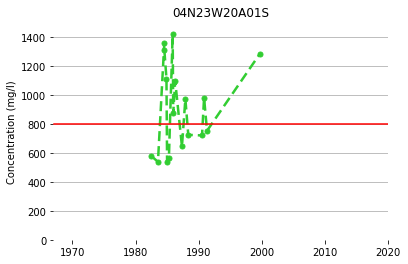

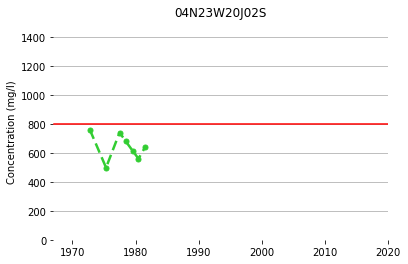

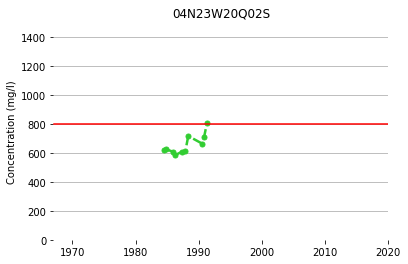

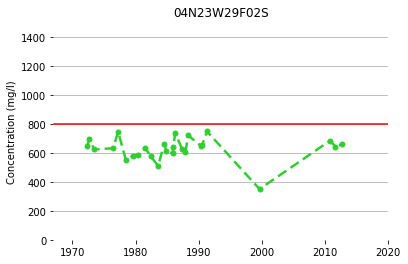

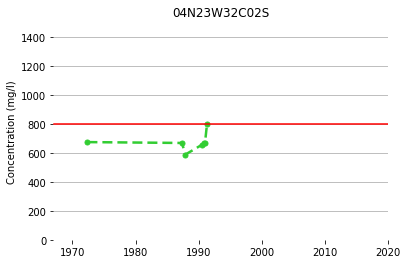

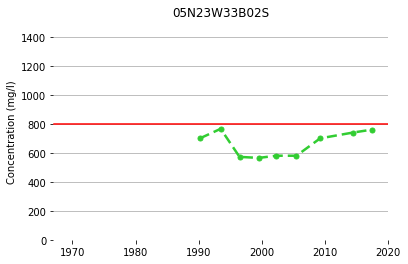

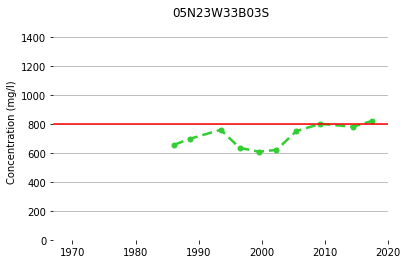

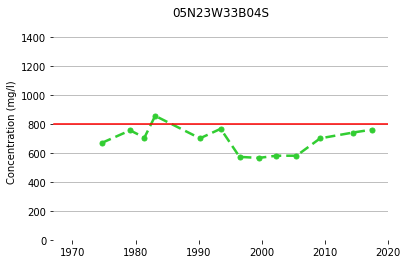

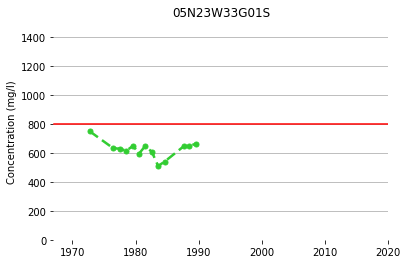

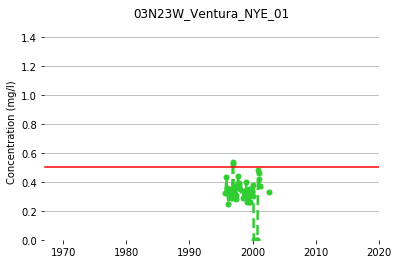

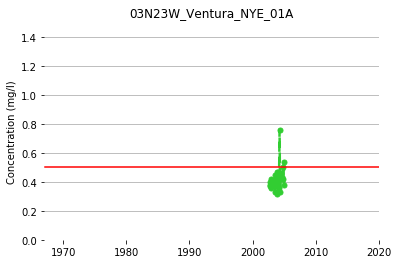

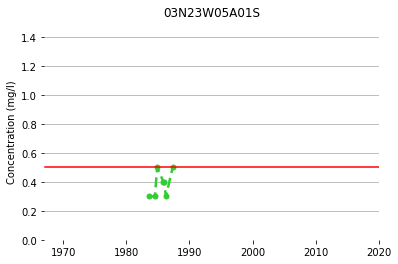

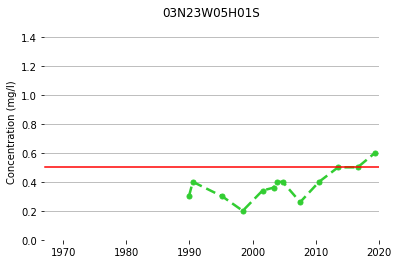

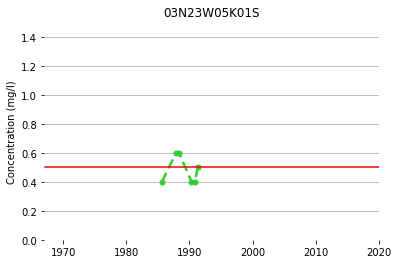

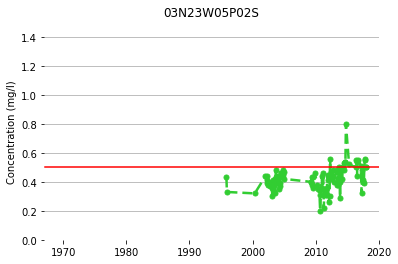

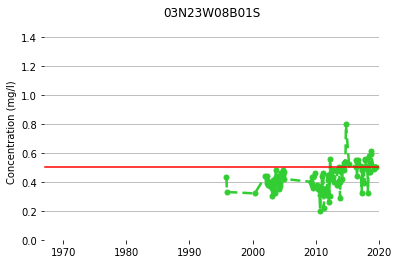

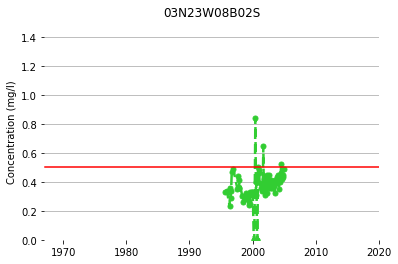

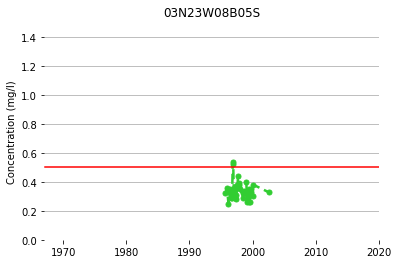

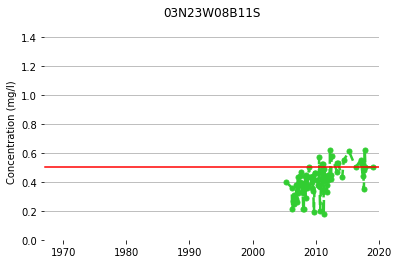

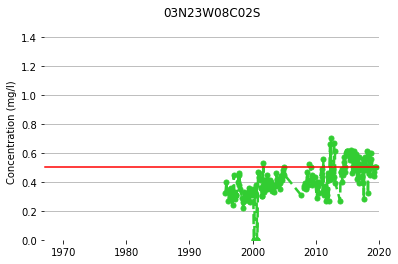

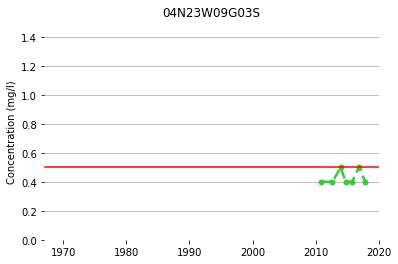

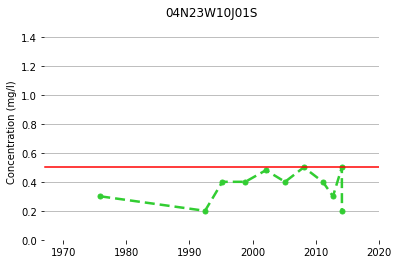

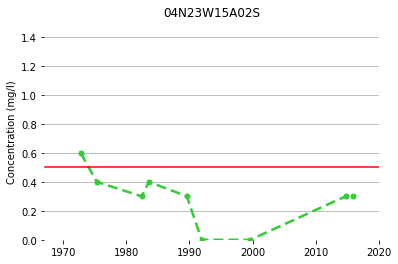

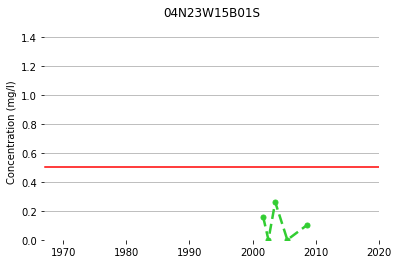

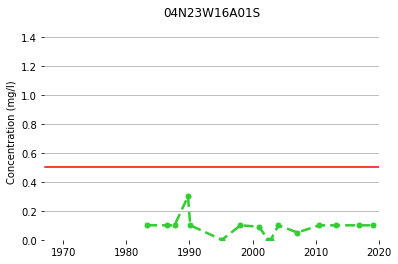

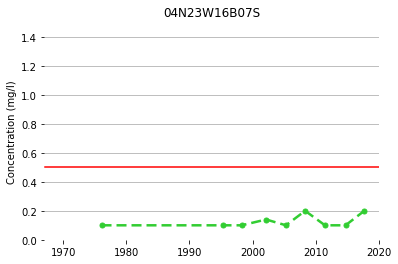

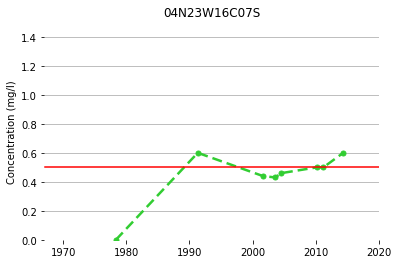

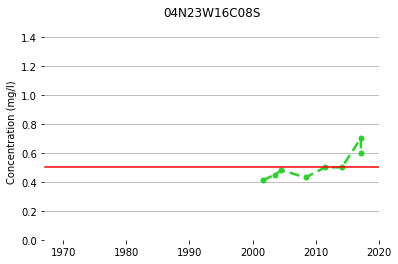

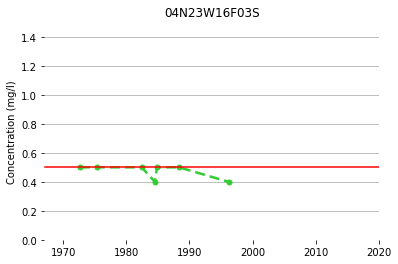

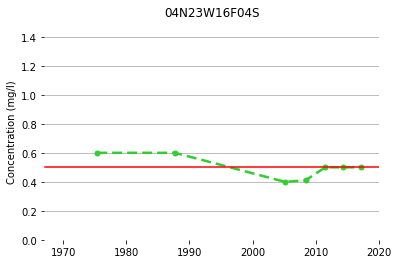

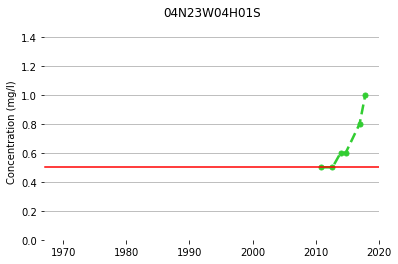

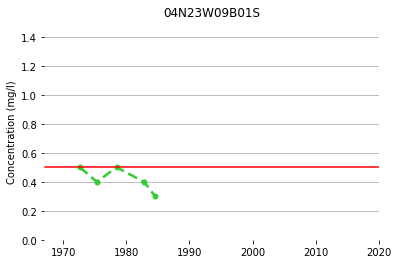

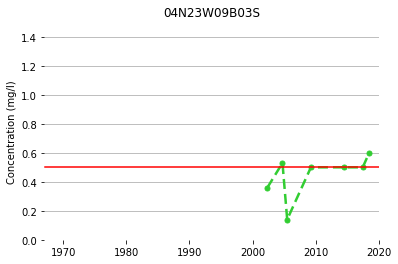

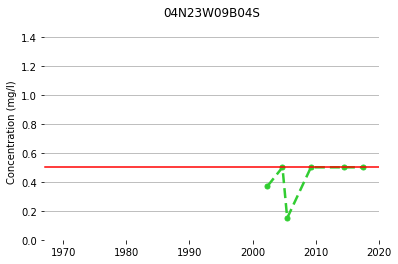

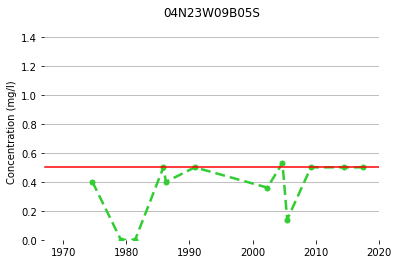

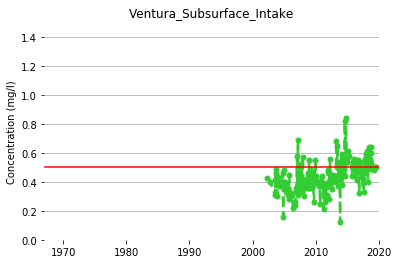

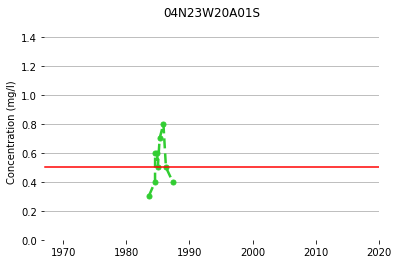

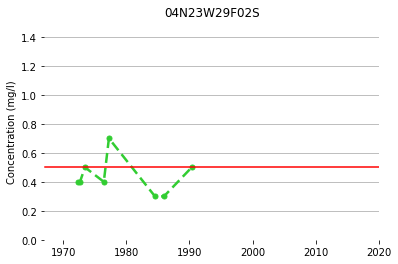

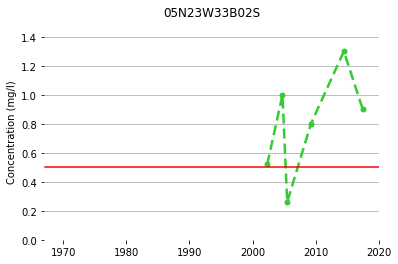

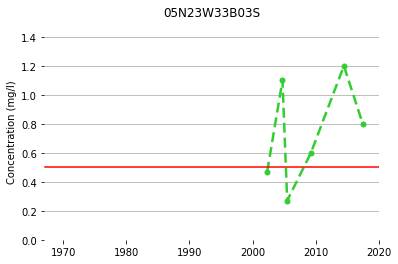

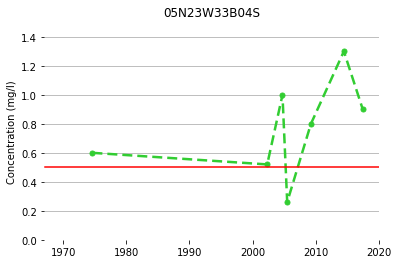

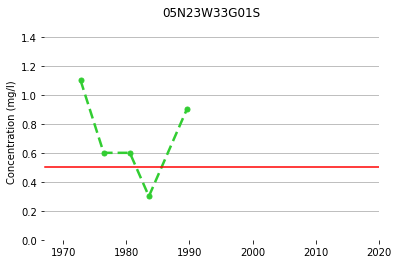

In [64]:
if __name__ == "__main__":
    plt_chemographs(threshold,begin,end,outpath)